In [53]:
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from matplotlib.dates import DayLocator, DateFormatter
from scipy.stats import shapiro, normaltest, kstest, ttest_1samp, levene
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns

In [3]:
#Załadowanie danych
data = pd.read_csv("powerconsumption.csv", usecols=["Datetime", "PowerConsumption_Zone1"])
data = data[:4465]
data["Datetime"] = pd.to_datetime(data["Datetime"])
#Partycja
data_train = data["PowerConsumption_Zone1"][:4019]
data_test = data["PowerConsumption_Zone1"][4019:]

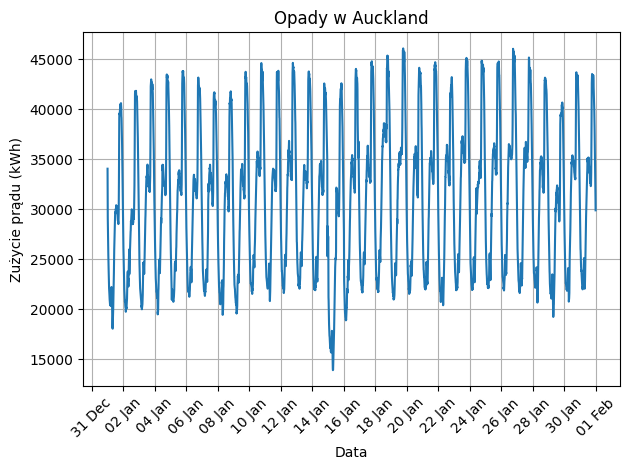

In [4]:
#Wizualizacja
plt.plot(data["Datetime"], data["PowerConsumption_Zone1"])
locator = DayLocator(interval=2)  # Adjust minticks/maxticks as needed
formatter = DateFormatter('%d %b')  # Display month and year, e.g., "Jan 2023"

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.xlabel("Data")
plt.ylabel("Zużycie prądu (kWh)")
plt.title("Opady w Auckland")
plt.grid()
plt.tight_layout()
plt.show()

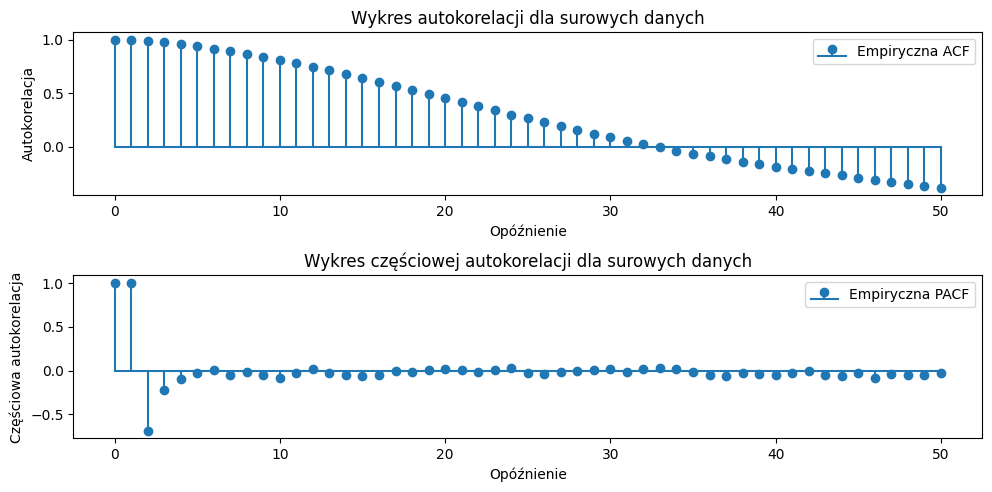

In [5]:
#acf i pacf dla surowych danych
h_max = 50

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)

autokor_emp = acf(data_train, nlags=h_max)

plt.stem(autokor_emp, basefmt='', label='Empiryczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Wykres autokorelacji dla surowych danych')
plt.legend()

plt.subplot(2, 1, 2)

pautokor_emp = pacf(data_train, nlags=h_max)

plt.stem(pautokor_emp, basefmt='', label='Empiryczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('Wykres częściowej autokorelacji dla surowych danych')
plt.legend()

plt.tight_layout(pad=1)
plt.show()

In [6]:
#test adf na stacjonarnosc
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [7]:
adfuller_test(data_train)

Statystyka testowa = -11.515, p-Value = 0.0 => Stationary. 


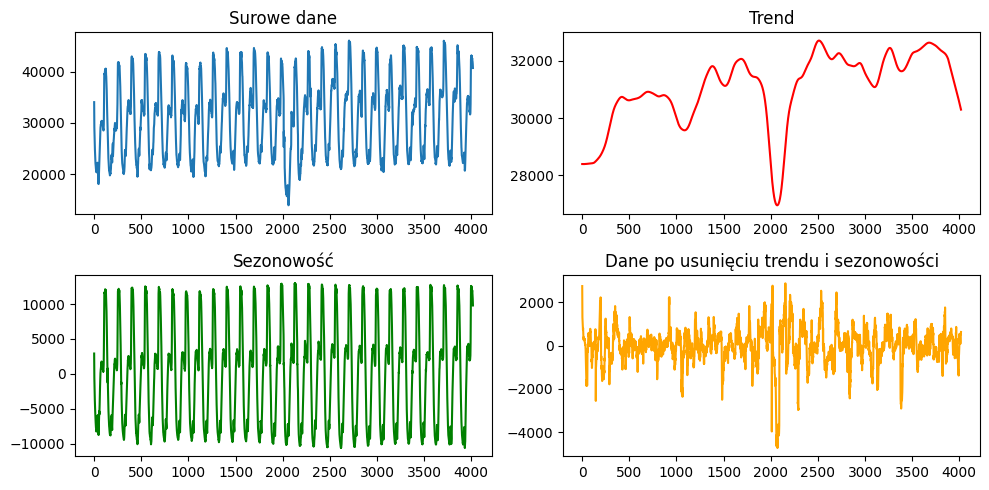

In [30]:
#dekompozycja szeregu
exp_decomposition = STL(data_train, period=144).fit()#ExponentialSmoothing(data_train, seasonal_periods=144, trend='add', seasonal='add').fit()#STL(data_train, period=144).fit()

trend_exp = exp_decomposition.trend
seasonal_exp = exp_decomposition.seasonal
clean_data = exp_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(data_train, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_exp, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_exp, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(clean_data, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

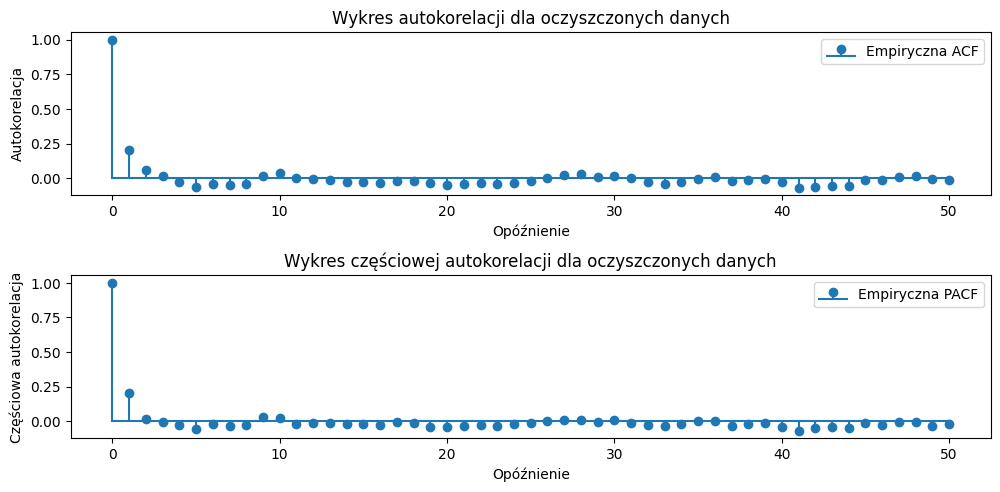

In [24]:
#acf i pacf dla oczyszczonych danych
h_max = 50

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)

autokor_emp = acf(clean_data, nlags=h_max)

plt.stem(autokor_emp, basefmt='', label='Empiryczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Wykres autokorelacji dla oczyszczonych danych')
plt.legend()

plt.subplot(2, 1, 2)

pautokor_emp = pacf(clean_data, nlags=h_max)

plt.stem(pautokor_emp, basefmt='', label='Empiryczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('Wykres częściowej autokorelacji dla oczyszczonych danych')
plt.legend()

plt.tight_layout(pad=1)
plt.show()

In [31]:
#dopasowanie modelu
model = pm.auto_arima(clean_data, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65418.115, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=56199.992, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61544.170, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=56202.038, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=56202.022, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=56204.057, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56201.926, Time=0.41 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.597 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4019
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -28097.996
Date:                Tue, 28 Jan 2025   AIC                          56199.992
Time:                        17:35:15   BIC                          56212.590
Sample:         

In [21]:
adfuller_test(clean_data)

Statystyka testowa = -10.876, p-Value = 0.0 => Stationary. 


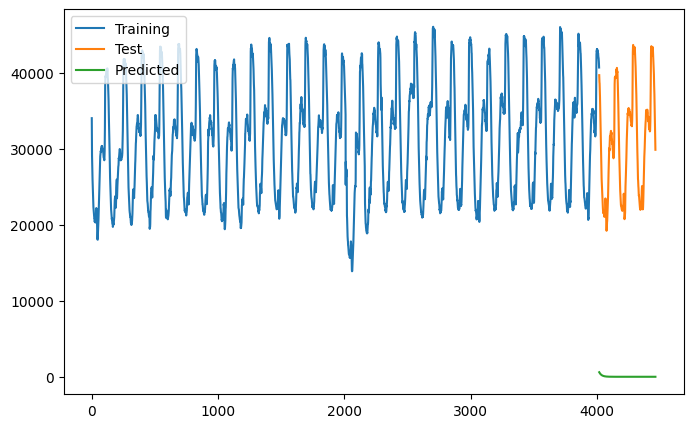

In [32]:
prediction = pd.DataFrame(model.predict(n_periods = len(data_test)), index=data_test.index)
prediction.columns = ['predicted']
plt.figure(figsize=(8,5))
plt.plot(data_train,label="Training")
plt.plot(data_test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('SecondPrection.jpg')
plt.show()



1. Test średniej reszt:
Średnia reszt nie różni się istotnie od zera (p=0.928).


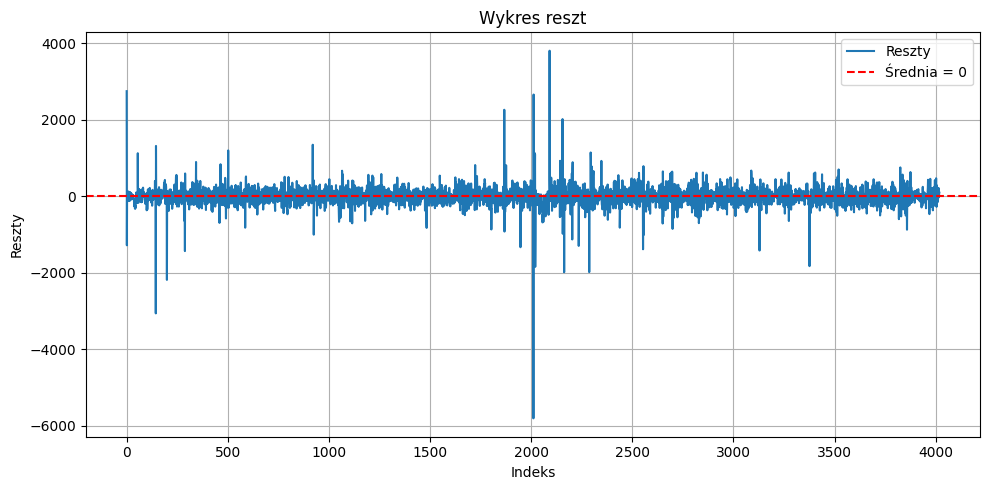

In [33]:
# Pobranie reszt modelu
residuals = model.resid()

# 1. Założenie dotyczące średniej
print("\n1. Test średniej reszt:")
t_stat, p_val_mean = ttest_1samp(residuals, 0)
if p_val_mean < 0.05:
    print(f"Reszty mają średnią statystycznie różną od zera (p={p_val_mean:.3f}).")
else:
    print(f"Średnia reszt nie różni się istotnie od zera (p={p_val_mean:.3f}).")

plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Reszty')
plt.axhline(0, color='red', linestyle='--', label='Średnia = 0')
plt.title('Wykres reszt')
plt.xlabel('Indeks')
plt.ylabel('Reszty')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


2. Testy wariancji reszt:


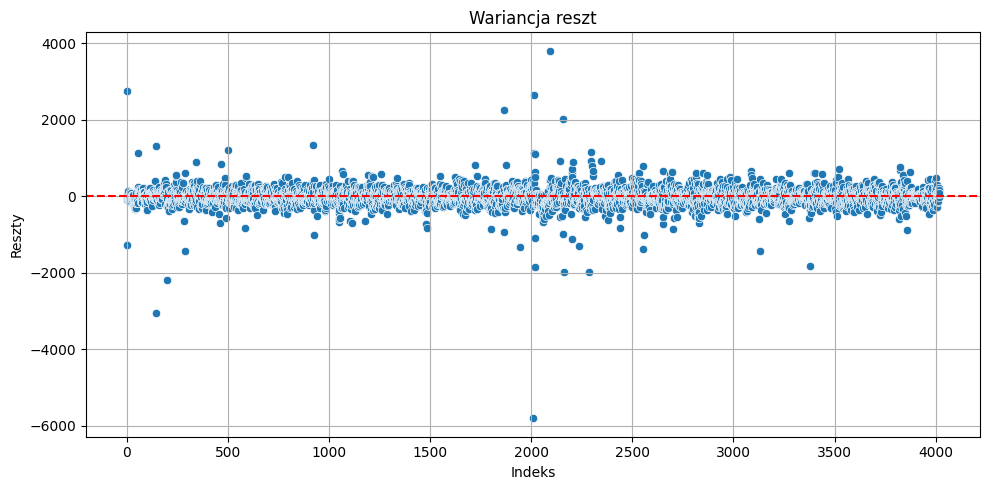

Reszty mają niestacjonarną wariancję (Levene test, p=0.001).


In [54]:
# 2. Założenie dotyczące wariancji
print("\n2. Testy wariancji reszt:")
# Wykres wartości resztowych
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(residuals)), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Wariancja reszt')
plt.xlabel('Indeks')
plt.ylabel('Reszty')
plt.grid()
plt.tight_layout()
plt.show()

# Modified Levene Test
half = len(residuals) // 2
levene_stat, levene_p_val = levene(residuals[:half], residuals[half:])
if levene_p_val < 0.05:
    print(f"Reszty mają niestacjonarną wariancję (Levene test, p={levene_p_val:.3f}).")
else:
    print(f"Wariancja reszt jest stacjonarna (Levene test, p={levene_p_val:.3f}).")


3. Test niezależności reszt:
Reszty są skorelowane (Ljung-Box test, p=0.000).


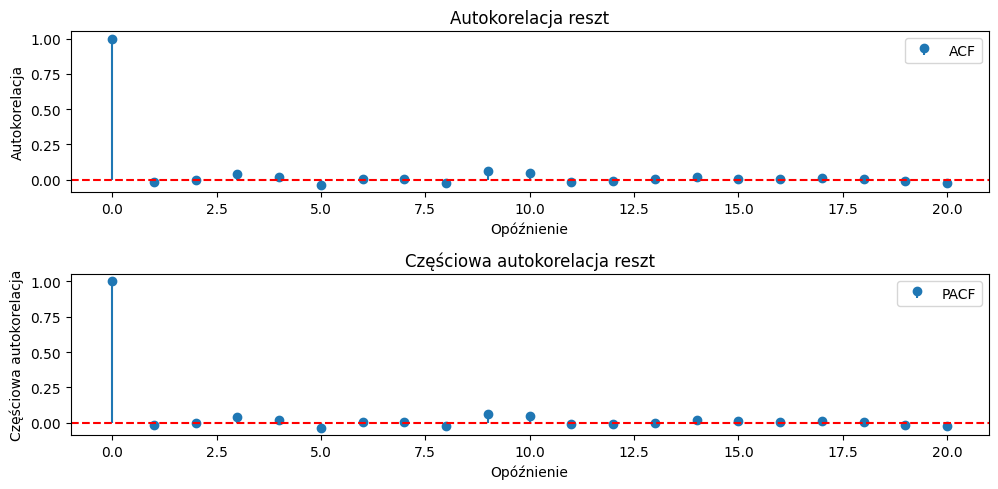

In [55]:
# 3. Założenie dotyczące niezależności
print("\n3. Test niezależności reszt:")
ljungbox_results = acorr_ljungbox(residuals, lags=[10])
ljungbox_p_val = ljungbox_results['lb_pvalue'].values[0]
if ljungbox_p_val < 0.05:
    print(f"Reszty są skorelowane (Ljung-Box test, p={ljungbox_p_val:.3f}).")
else:
    print(f"Reszty nie są skorelowane (Ljung-Box test, p={ljungbox_p_val:.3f}).")

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.stem(acf(residuals, nlags=20), basefmt=' ', label='ACF')
plt.axhline(0, color='red', linestyle='--')
plt.title('Autokorelacja reszt')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.legend()

plt.subplot(2, 1, 2)
plt.stem(pacf(residuals, nlags=20), basefmt=' ', label='PACF')
plt.axhline(0, color='red', linestyle='--')
plt.title('Częściowa autokorelacja reszt')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.legend()

plt.tight_layout()
plt.show()


4. Testy normalności reszt:


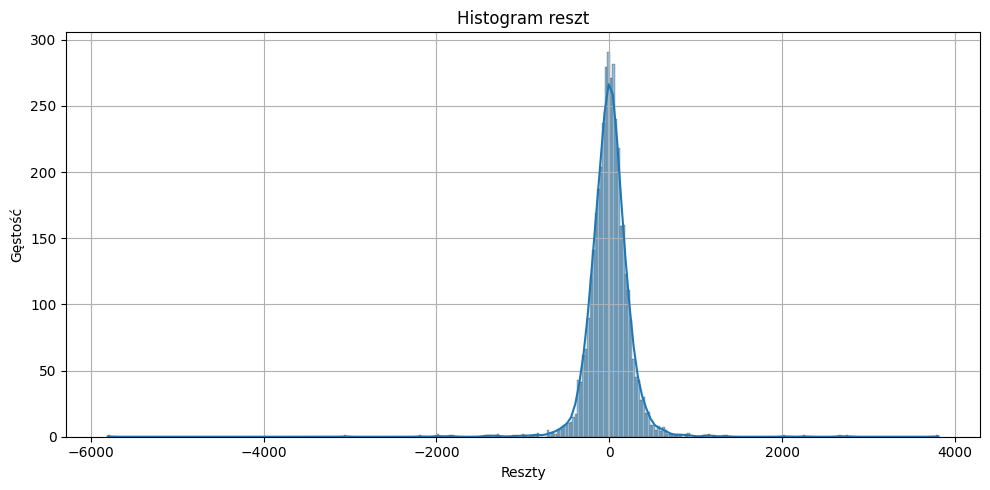

Reszty nie mają rozkładu normalnego (Shapiro-Wilk test, p=0.000).
Reszty nie mają rozkładu normalnego (Kolmogorov-Smirnov test, p=0.000).


In [51]:
# 4. Założenie dotyczące normalności
print("\n4. Testy normalności reszt:")
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Histogram reszt')
plt.xlabel('Reszty')
plt.ylabel('Gęstość')
plt.grid()
plt.tight_layout()
plt.show()

# Testy na normalność
shapiro_stat, shapiro_p = shapiro(residuals)
if shapiro_p < 0.05:
    print(f"Reszty nie mają rozkładu normalnego (Shapiro-Wilk test, p={shapiro_p:.3f}).")
else:
    print(f"Reszty mają rozkład normalny (Shapiro-Wilk test, p={shapiro_p:.3f}).")

kst_stat, kst_p = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
if kst_p < 0.05:
    print(f"Reszty nie mają rozkładu normalnego (Kolmogorov-Smirnov test, p={kst_p:.3f}).")
else:
    print(f"Reszty mają rozkład normalny (Kolmogorov-Smirnov test, p={kst_p:.3f}).")

c:\Users\julka\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


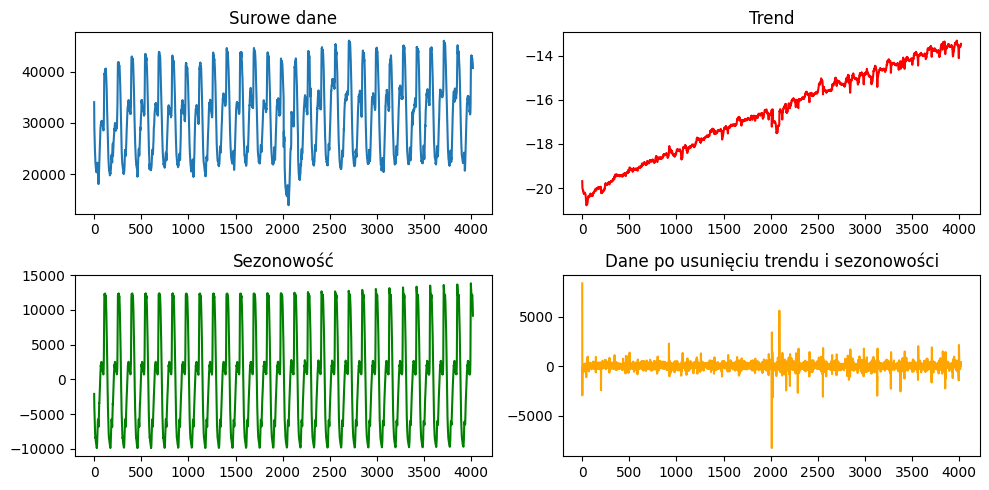

In [59]:
#dekompozycja szeregu
exp_decomposition = ExponentialSmoothing(data_train, seasonal_periods=144, trend='add', seasonal='add').fit()#STL(data_train, period=144).fit()

trend_exp = exp_decomposition.trend
seasonal_exp = exp_decomposition.season
clean_data = exp_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(data_train, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_exp, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_exp, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(clean_data, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [60]:
#dopasowanie modelu
model1 = pm.auto_arima(clean_data, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59896.234, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59709.635, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=59721.105, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=59711.317, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=59711.323, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=59686.650, Time=0.95 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=59715.245, Time=0.79 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=59715.320, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=59713.303, Time=1.28 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=59713.317, Time=0.63 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=3.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=59709.919, Time=2.81 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 12.167 seconds
                               SARIMAX Results                                
De

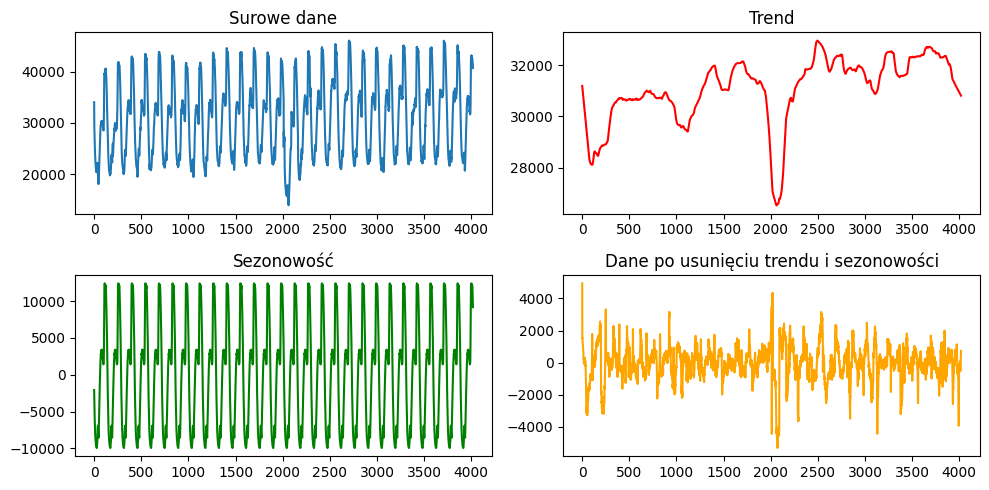

In [66]:
decomposition = seasonal_decompose(data_train, model='additive', period=144, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(data_train, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [67]:
#dopasowanie modelu
model2 = pm.auto_arima(residual, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67447.034, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58205.713, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=63445.850, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=58157.895, Time=0.48 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=58159.895, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=58159.895, Time=0.53 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=58158.304, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=58163.207, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=58159.911, Time=1.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 3.990 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4019
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -28097.996
Date:                Tue, 28 Jan 2025   

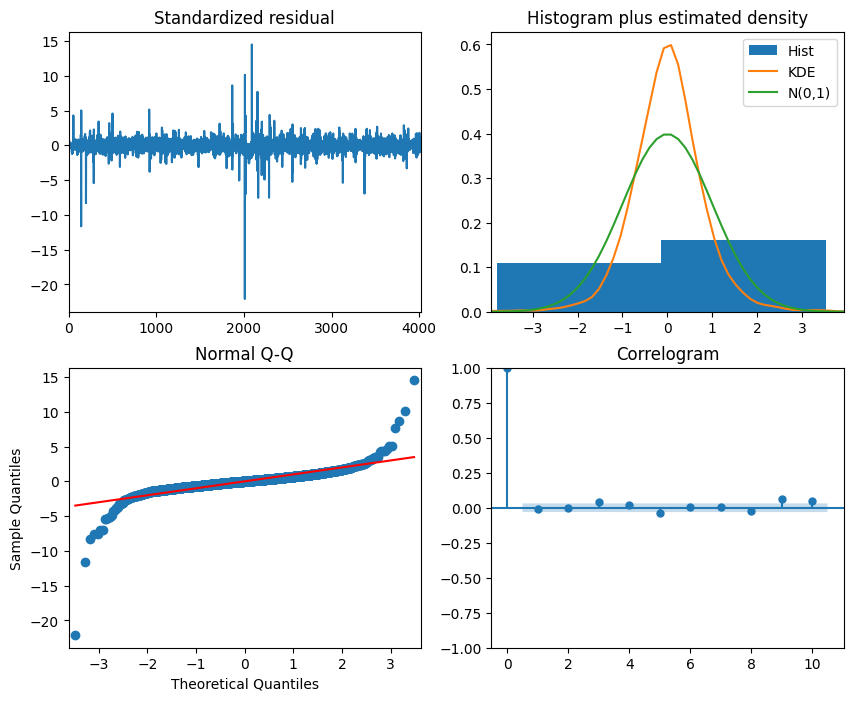

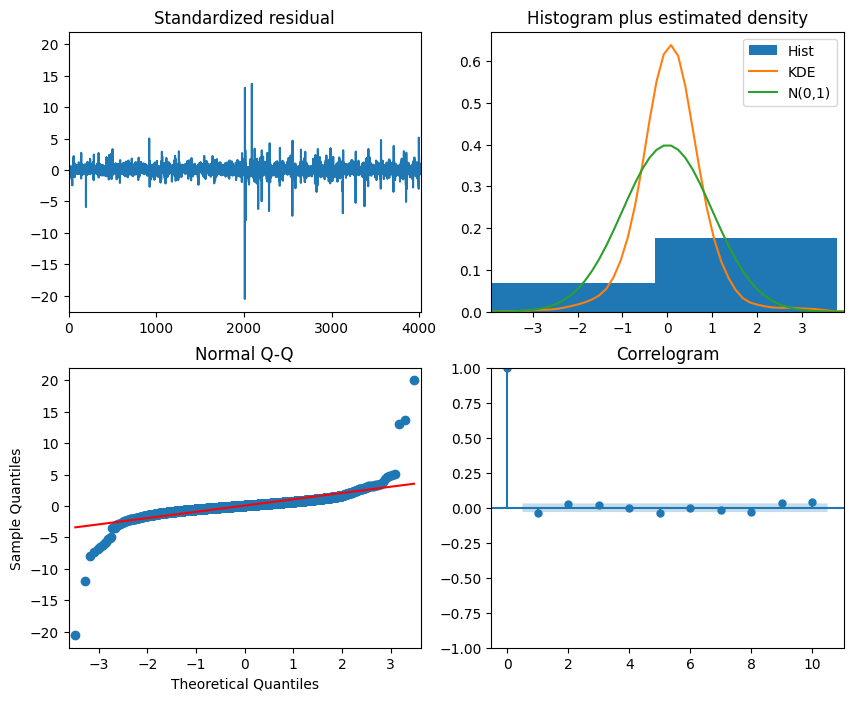

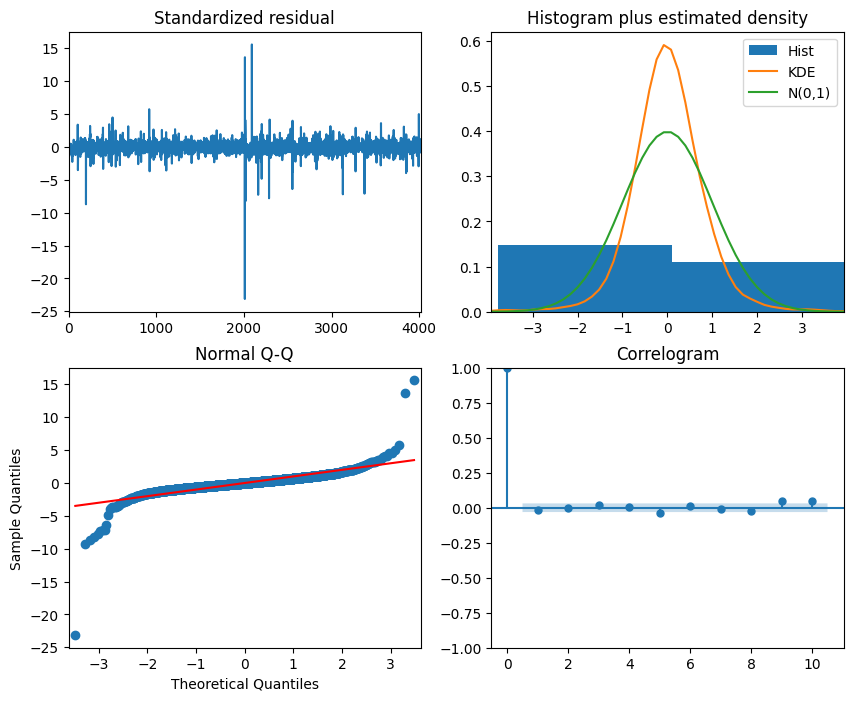

In [72]:
model.plot_diagnostics(figsize=(10, 8))
model1.plot_diagnostics(figsize=(10, 8))
model2.plot_diagnostics(figsize=(10, 8))
plt.show()